In [1]:
%config InlineBackend.figure_format = 'retina'


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


In [3]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
states = pd.read_csv(url,
                     usecols=[0,1,3],
                     index_col=['state', 'date'],
                     parse_dates=['date']).sort_index()


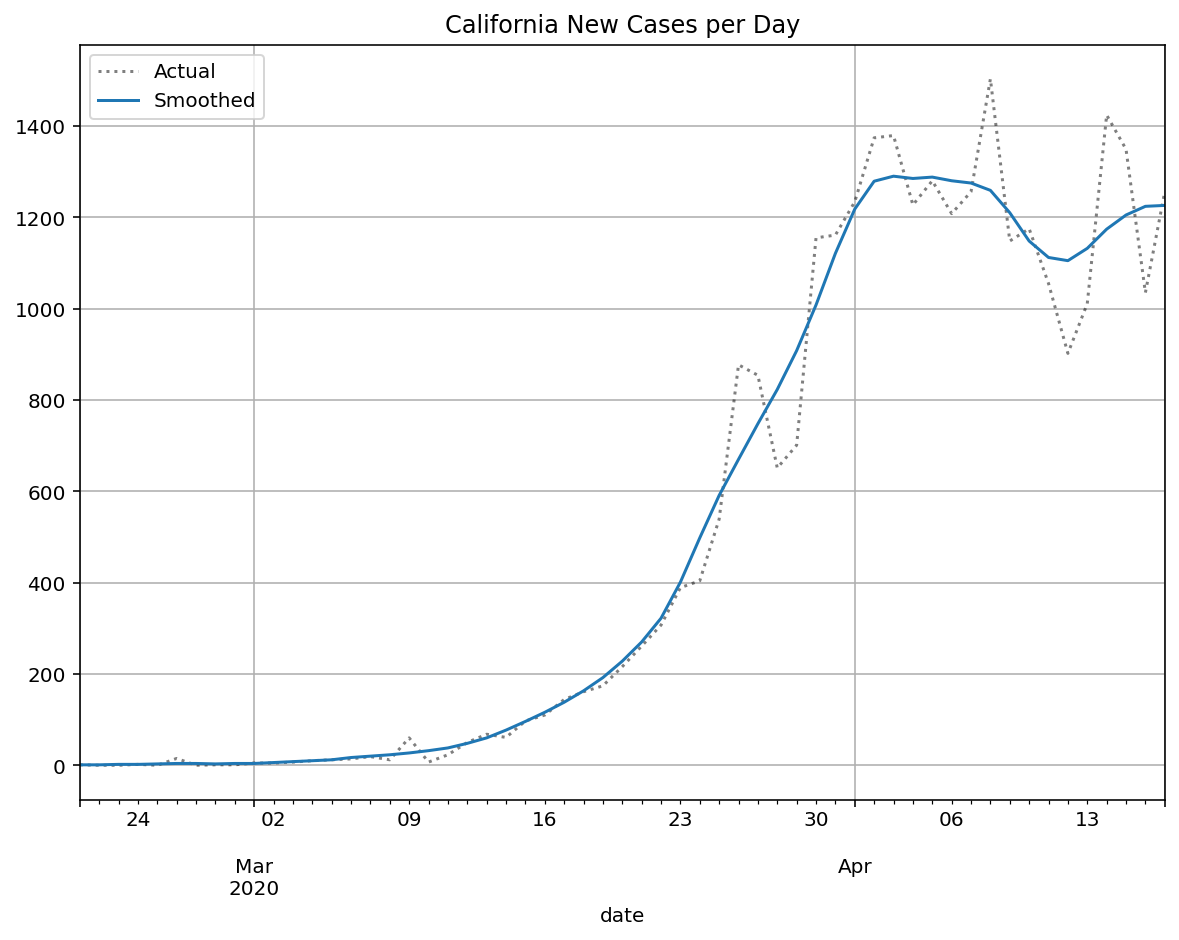

In [4]:
state_name = 'California'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(5,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name)\
    .squeeze()\
    .rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               grid=True,
               label='Actual',
               legend=True,
               figsize=(700/72, 500/72))

ax = smoothed.plot(label='Smoothed', legend=True, grid=True)
ax.get_figure().set_facecolor('w')


In [5]:
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
counties = pd.read_csv(url,
                     usecols=[0,1,2,4],
                     index_col=['county', 'date'],
                     parse_dates=['date'],
                     squeeze=True)

counties = counties[counties.state=='California']\
    .drop(columns=['state'])\
    .sort_index()


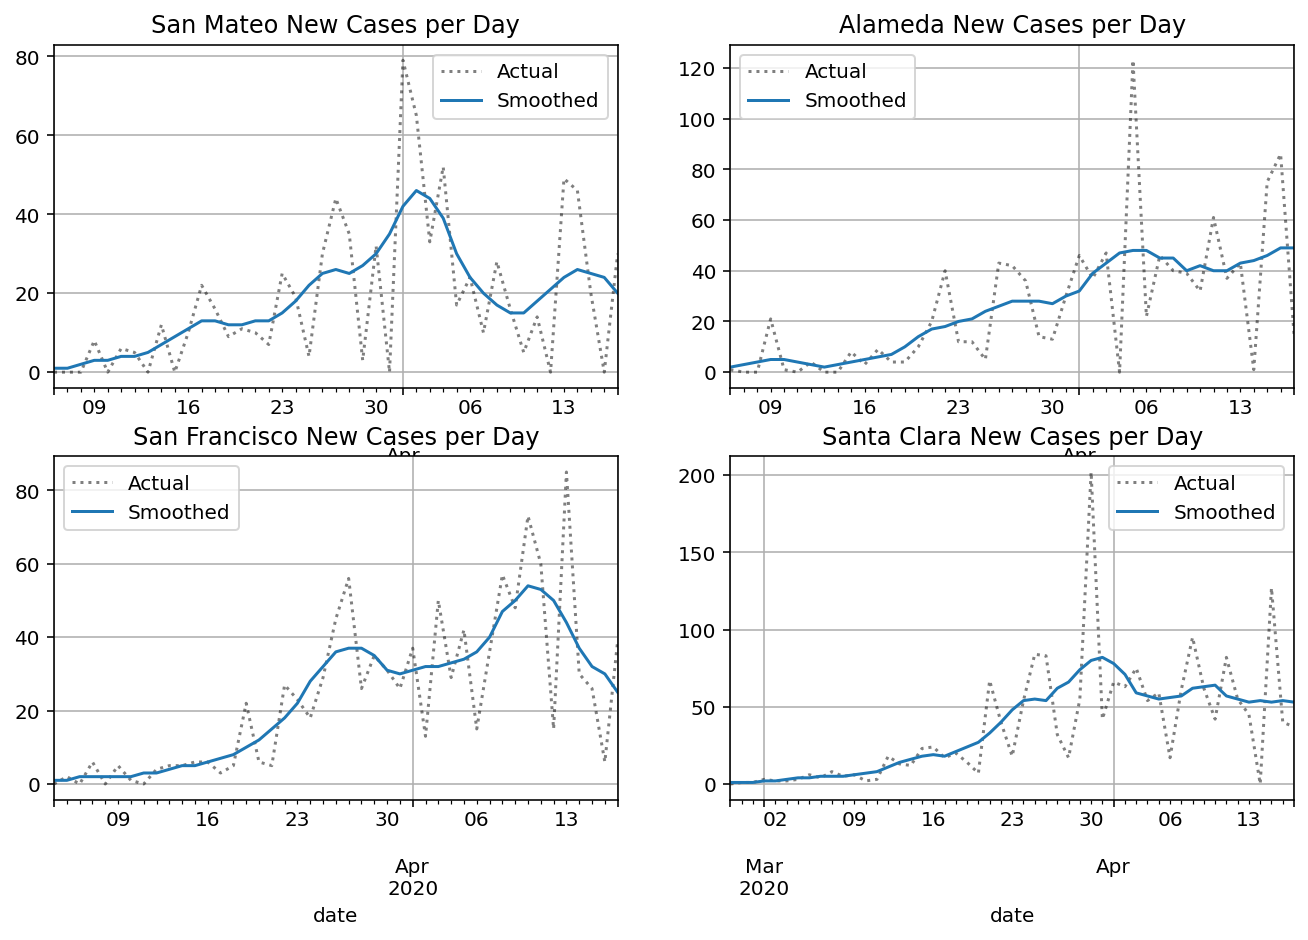

In [6]:


def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(5,
        win_type='gaussian',
        min_periods=0,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

county_names = ['San Mateo', 'Alameda', 'San Francisco', 'Santa Clara']

fig, axs = plt.subplots(2, 2)

for i, county_name in enumerate(county_names):
    coords = [int(x) for x in list(f"{i:02b}")]
    ax = axs[coords[0], coords[1]]
    
    cases = counties.xs(county_name)\
        .squeeze()\
        .rename(f"{county_name} cases")

    original, smoothed = prepare_cases(cases)

    original.plot(title=f"{county_name} New Cases per Day",
                  c='k',
                  linestyle=':',
                  alpha=.5,
                  label='Actual',
                  legend=True,
                  grid=True,
                  figsize=(800/72, 500/72),
                  ax=ax)

    smoothed.plot(label='Smoothed', legend=True, grid=True, ax=ax)
    fig.set_facecolor('w')
